In [18]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt

In [19]:
def split_entire_audio(female, male, mix):
    
    n_fft = 1024
    hop_length = 256#8
    sr = 16000
    
    # compute stft for both audio files -> works better when calling librosa.mono -> forces the audio signal to go down to mono
    stft_1 = librosa.stft(librosa.to_mono(female), window='hann', n_fft=n_fft, hop_length=hop_length)    
    stft_2 = librosa.stft(librosa.to_mono(male), window='hann', n_fft=n_fft, hop_length=hop_length)    
    stft_mix = librosa.stft(librosa.to_mono(mix), window='hann', n_fft=n_fft, hop_length=hop_length)

    
    # get mask for entire audio
    mask_1 = my_utils.compute_mask(stft_1, stft_2)
    mask_2 = my_utils.compute_mask(stft_2, stft_1)
    print(mask_1)

#     mask_1 = librosa.util.softmask(np.abs(stft_1), np.abs(stft_2))
#     mask_2 = librosa.util.softmask(np.abs(stft_2), np.abs(stft_1))
    
    first_sound_stft = my_utils.get_stft_matrix_from_mixture(mask_1, stft_mix)
    second_sound_stft = my_utils.get_stft_matrix_from_mixture(mask_2, stft_mix)

#     plt.figure(figsize=(12, 8))
#     plt.subplot(3, 1, 1)
#     librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_mix[:2]), ref=np.max),
#                              y_axis='log', sr=sr)
#     plt.title('stft_mix')
#     plt.colorbar()

#     plt.subplot(3, 1, 2)
#     librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_1[:2]), ref=np.max),
#                              y_axis='log', sr=sr)
#     plt.title('first_sound_stft')
#     plt.colorbar()
#     plt.subplot(3, 1, 3)
#     librosa.display.specshow(librosa.amplitude_to_db(np.abs(first_sound_stft[:2]), ref=np.max),
#                              y_axis='log', x_axis='time', sr=sr)
#     plt.title('first_sound_stft after masking')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
    
    inverse_sound1_stft = librosa.istft(first_sound_stft, hop_length=hop_length, window='hann')
    inverse_sound2_stft = librosa.istft(second_sound_stft, hop_length=hop_length, window='hann')
#     print(inverse_sound1_stft[:10])
    
    librosa.output.write_wav("../recordings/recover-full-female-2.wav", inverse_sound1_stft, sr = 16000)
    librosa.output.write_wav("../recordings/recover-full-male-2.wav", inverse_sound2_stft, sr = 16000)

In [20]:
def split_audio_using_small_segments(female_filename, male_filename):    
    
    n_fft = 1024
    hop_length = 8
    mix_filename= my_utils.mix_audios(male_filename, female_filename)
    
    male = AudioSegment.from_wav(male_filename)
    female = AudioSegment.from_wav(female_filename)
    mix = AudioSegment.from_wav(mix_filename)

    sound1 = np.empty([0,])
    sound2 = np.empty([0,])
    sound = np.empty([0,])
    
    total_ms = mix.__len__()
    frame_size_ms = 100
    i = 0
    
    while i * frame_size_ms < total_ms:
        start = i * frame_size_ms
        stop = i * frame_size_ms + frame_size_ms
        
        # use the hop size at 50% of the frame size: for fs = 500, 0->500; 250->750; 500->1000...
#         start = i * (frame_size_ms / 2)
#         stop = i * (frame_size_ms / 2) + frame_size_ms
        
        # in case the frame size goes above mix length
        if stop > total_ms:
            fs = total_ms - start
            stop = i * frame_size_ms + fs
            
        # get frames from all audio signals, type = audiosegment
        frame_1 = my_utils.get_specific_frame_in_ms(female, start, stop)
        frame_2 = my_utils.get_specific_frame_in_ms(male, start, stop)
        frame_mix = my_utils.get_specific_frame_in_ms(mix,start, stop)


        # from audio segment convert to ndarray how librosa uses
        frame_1, r = my_utils.audiosegment_to_ndarray(frame_1)
        frame_2, r = my_utils.audiosegment_to_ndarray(frame_2)
        frame_mix, r = my_utils.audiosegment_to_ndarray(frame_mix)
        
#         print("length of ndarray of frame ",frame_1.shape)

        frame_1, frame_mix = my_utils.make_wav_files_same_size(frame_1, frame_mix)
        frame_2, frame_mix = my_utils.make_wav_files_same_size(frame_2, frame_mix)
#         print("duration window: ",librosa.get_duration(y=frame_1, sr=16000))
          
        # compute the stft for each of them
        frame_1_stft = librosa.stft(librosa.to_mono(frame_1), window='hann', n_fft=n_fft, hop_length=hop_length)
        frame_2_stft = librosa.stft(librosa.to_mono(frame_2), window='hann', n_fft=n_fft, hop_length=hop_length)
        frame_mix_stft = librosa.stft(librosa.to_mono(frame_mix), window='hann', n_fft=n_fft, hop_length=hop_length)
        
#         inverse_sound1_stft = librosa.istft(frame_1_stft, hop_length=hop_length, window='hann')
#         inverse_sound2_stft = librosa.istft(frame_2_stft, hop_length=hop_length, window='hann')
        
        # compute masks for current frame
        mask_1 = my_utils.compute_mask(frame_1_stft, frame_2_stft)
        mask_2 = my_utils.compute_mask(frame_2_stft, frame_1_stft)
        
#         mask_1 = librosa.util.softmask(np.abs(frame_1_stft), np.abs(frame_2_stft), power=1000)
#         mask_2 = librosa.util.softmask(np.abs(frame_2_stft), np.abs(frame_1_stft), power=1000)

        # get sound for each source of i-th frame
        y_frame_1_stft_with_mask = mask_1 * frame_mix_stft
        y_frame_2_stft_with_mask = mask_2 * frame_mix_stft
        
        inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
        inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')
        print("masca: ", mask_1)
#         inverse_sound_mix_stft = librosa.istft(inv, hop_length=hop_length, window='hann')

        sound1 = np.concatenate((sound1, inverse_sound1_stft))
        sound2 = np.concatenate((sound2, inverse_sound2_stft))

        if i == 0:
            sr = 16000
            plt.figure(figsize=(12, 8))
            plt.subplot(3, 1, 1)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(frame_1_stft.transpose()), ref=np.max),
                                     y_axis='log', sr=sr)
            plt.title('female - original segment STFT')
            plt.colorbar()

            plt.subplot(3, 1, 2)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(frame_mix_stft.transpose()), ref=np.max),
                                     y_axis='log', sr=sr)
            plt.title('mix - segment STFT')
            plt.colorbar()
            plt.subplot(3, 1, 3)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_frame_1_stft_with_mask.transpose()), ref=np.max),
                                     y_axis='log', x_axis='time', sr=sr)
            plt.title('female - segment with mask STFT')
            plt.colorbar()
            plt.tight_layout()
            plt.show()
            
        i += 1


    sound1_start, sound1_end = mix_filename.index('arctic'), mix_filename.index('.wav')
    name = "../recordings/rec_" + mix_filename[sound1_start:sound1_end]

    
    sound1 = my_utils.delete_final_zeros_for_silence(sound1)
    sound2 = my_utils.delete_final_zeros_for_silence(sound2)
#     print("sound final: ", sound1[315:321], sep='\n')
        
    librosa.output.write_wav(name + '_female.wav', sound1, sr = 16000)
    librosa.output.write_wav(name + '_male.wav', sound2, sr = 16000)
#     librosa.output.write_wav(name + '_MIX-seg.wav', sound, sr = 16000)

masca:  [[0.00121991 0.00122354 0.0012341  ... 0.72856444 0.73034066 0.73082465]
 [0.00219125 0.00218734 0.00217594 ... 0.13296756 0.12920125 0.12815148]
 [0.00111552 0.00113803 0.00120283 ... 0.43617773 0.43830147 0.43888742]
 ...
 [0.38502258 0.38460675 0.3833457  ... 0.5621337  0.578469   0.5832552 ]
 [0.537369   0.5369678  0.53577155 ... 0.20471019 0.204899   0.20494875]
 [0.40357894 0.40356633 0.40352568 ... 0.15787137 0.15782702 0.15781528]]


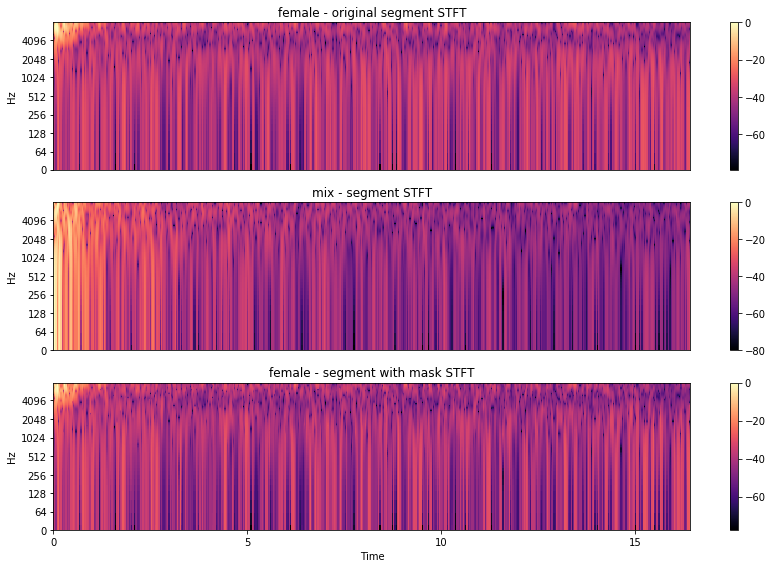

masca:  [[0.02192239 0.02192368 0.02192615 ... 0.7620275  0.76268506 0.76286316]
 [0.05404314 0.05413984 0.05442722 ... 0.87495273 0.87474024 0.8746824 ]
 [0.34734344 0.34604582 0.34229547 ... 0.9049948  0.90492207 0.9049019 ]
 ...
 [0.77878124 0.7785669  0.77784157 ... 0.42797628 0.43057916 0.43024632]
 [0.57910913 0.5788497  0.5780786  ... 0.49656135 0.4920927  0.49236813]
 [0.41925427 0.41912058 0.41870874 ... 0.26130956 0.27425447 0.27351382]]
masca:  [[0.9112355  0.9114165  0.911915   ... 0.999715   0.999827   0.99985737]
 [0.9559804  0.9557601  0.9551191  ... 0.96658236 0.96672076 0.96675694]
 [0.81066364 0.81054556 0.8100855  ... 0.97014177 0.97036594 0.9704286 ]
 ...
 [0.9695657  0.9695366  0.96945655 ... 0.8885795  0.88858265 0.888581  ]
 [0.95098853 0.9510133  0.9510816  ... 0.8368966  0.8369128  0.8369196 ]
 [0.9400979  0.9400641  0.939968   ... 0.8089179  0.80896354 0.80897355]]
masca:  [[0.98618853 0.98621446 0.9862925  ... 0.04650591 0.04661959 0.04665064]
 [0.9826571  0.

masca:  [[0.4290887  0.42882052 0.42812842 ... 0.82567674 0.82593316 0.82599944]
 [0.51786816 0.5179989  0.5182641  ... 0.9699435  0.9733768  0.9743984 ]
 [0.9449795  0.94265294 0.9361957  ... 0.87659246 0.87667364 0.87669355]
 ...
 [0.09770883 0.09764317 0.09744468 ... 0.02818735 0.02826077 0.02828068]
 [0.10081802 0.10087883 0.10106346 ... 0.14404902 0.14821814 0.14942507]
 [0.06976509 0.06970999 0.06954242 ... 0.04859155 0.04853415 0.04851765]]
masca:  [[0.90988654 0.9095089  0.9083806  ... 0.02347839 0.02369869 0.02375806]
 [0.987157   0.98693275 0.9862095  ... 0.19947033 0.2039037  0.20517665]
 [0.97402024 0.97351474 0.9720485  ... 0.10432708 0.10397821 0.10388175]
 ...
 [0.04504858 0.04501239 0.04499454 ... 0.9678458  0.9695222  0.9699992 ]
 [0.03933135 0.03935366 0.03934107 ... 0.8636756  0.86425906 0.86441904]
 [0.0427933  0.04277263 0.04279251 ... 0.7121861  0.7127291  0.7128727 ]]
masca:  [[0.0117665  0.01167527 0.01140134 ... 0.22364588 0.22392163 0.22410521]
 [0.05608005 0.

In [21]:
male_filename = '../recordings/male1/arctic_a0271.wav'
female_filename = '../recordings/female1/arctic_a0161.wav'

# for entire audio
# female, male, mix = my_utils.load_and_mix_files(female_filename, male_filename)
# split_entire_audio(female, male, mix)

#---------------------------------------
# split audio in segments
# mix is created inside function
split_audio_using_small_segments(female_filename, male_filename)